In [1]:
from scipy.special import iv
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxl') 

In [2]:
# AUXILIARY FUNCTIONS

import QuantLib as ql
import math
import matplotlib.pyplot as plt
import numpy as np

def nn(t):
    '''
    Count the times of LPR updates from by t within year 202X
    t: e.g. ql.Date(25,10,2022)
    '''
    upds = 0
    date, mon, year = t.dayOfMonth(), t.month(), t.year()
    if ql.Date(20, mon, year).weekday() == ql.Saturday:
        ann_date = 22
        if date < ann_date:
            upds = mon - 1
        else:
            upds = mon
    if ql.Date(20, mon, year).weekday() == ql.Sunday:
        ann_date = 21
        if date < ann_date:
            upds = mon - 1
        else:
            upds = mon
    elif date < 20:
        upds = mon - 1
    else:
        upds = mon

    return upds


def n(t, T):
    '''
    Count the times of LPR updates from t to T
    e.g.
    t: ql.Date(16,9,2021)
    T: ql.Date(25,10,2022)
    '''
    date1, mon1, year1 = t.dayOfMonth(), t.month(), t.year()
    date2, mon2, year2 = T.dayOfMonth(), T.month(), T.year()

    if year2 - year1 > 0:
        inter_upds = 12 * (year2 - year1 - 1)
        early_upds = 12 - nn(t)
        late_upds = nn(T)
        all_upds = early_upds + inter_upds + late_upds
    else:
        all_upds = nn(T) - nn(t)

    return all_upds


def P(r,t,T):
    '''
    return:the time-t value of the zero-coupon bond with maturity at T
    t:ql.Date object
    T:ql.Date object
    '''
    delta_year = (T-t)/365
    return math.exp(-r*delta_year)


def black_call_Cpl(K, start_date, F_2_0, T_1, T_2, sigma, r=0.03):
    t_1 = (T_1 - start_date) / 365
    eta = (T_2 - T_1)/365
    d_plus = (math.log(F_2_0/K) + t_1*(sigma**2)/2) / (sigma*(t_1)**(0.5))
    d_minus = (math.log(F_2_0/K) - t_1*(sigma**2)/2) / (sigma*(t_1)**(0.5))
    from scipy.stats import norm
    return eta*P(r,start_date,T_2)*(F_2_0*norm.cdf(d_plus, loc=0, scale=1) - K*norm.cdf(d_minus, loc=0, scale=1))


def bachelier_call_Cpl(K, start_date, F_2_0, T_1, T_2, sigma, r=0.03):
    t_1 = (T_1 - start_date) / 365
    eta = (T_2 - T_1)/365
    d_N = (F_2_0 - K) / (sigma*(t_1)**(0.5))
    from scipy.stats import norm
    return eta*P(r,start_date,T_2)*sigma*((t_1)**(0.5))*(d_N*norm.cdf(d_N)+ norm.pdf(d_N))


def relat_black_sigma(Ks):
    from jupyterthemes import jtplot
    jtplot.style(theme='gruvboxl') 
    plt.figure(figsize=(22,11))
    num=0
    xx = np.linspace(0.02, 0.09, 40)
    for K in Ks:
        num+=1
        sub=230+num
        ax=plt.subplot(sub)
        yy = [1000000*black_call_Cpl(K=K, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021), sigma=i, r=0.03) for i in xx]
        plt.plot(xx, yy, lw=0.8, c='blue')
#         ax.set_ylim([2300,2700])
        plt.title('K={}'.format(K))
        plt.grid('True',ls='--')
        plt.legend(['Black Price'], loc='upper left')
    plt.show()


def relat_bachelier_sigma(Ks):
    from jupyterthemes import jtplot
    jtplot.style(theme='gruvboxl') 
    plt.figure(figsize=(22,11))
    num=0
    xx = np.linspace(0.0015, 0.0022, 40)
    for K in Ks:
        num+=1
        sub=230+num
        ax=plt.subplot(sub)
        yy = [1000000*bachelier_call_Cpl(K=K, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021), sigma=i, r=0.03) for i in xx]
        plt.plot(xx, yy, lw=0.8, c='blue')
        plt.title('K={}'.format(K))
        plt.grid('True',ls='--')
        plt.legend(['Bachelier Price'], loc='upper left')
    plt.show()

In [3]:
# MAIN FUNCTION 1

def call_Cpl(K, lambda_2, start_date, F_2_0, T_1, T_2, b=0.0005, r=0.03):
    '''
    lambda_2: the intensity parameter under T_2-forward measure Q_2
    K: the strike of the 2nd caplet
    start_date: ql.Date object (the date of evaluation)
    T_1: ql.Date object
    T_2: ql.Date object
    F_2_0: the time-(start_date) simple forward rate for period [T_1,T_2]
    '''
    k = (K - F_2_0) / b
    eta = (T_2 - T_1)/365    # ACT/365
    def sum_calc():
        total = 0
        N = 500
        start = math.ceil(k)
        for d in range(start,N):
            bessel = iv( abs(d), 2*n(start_date, T_1)*lambda_2 )
            ind = (d-k) * math.exp(-2*n(start_date, T_1)*lambda_2) * bessel
            total += ind
        return total
    return b*eta*P(r,start_date,T_2)*sum_calc()

In [4]:
# MAIN FUNCTION 2

def black_call_imp_vol_dichotomy(c, K, start_date, F_2_0, T_1, T_2, r=0.03, it=100, thresh=1e-16):
    '''
    c: the price of the ith caplet derived from SMM
    K: the strike of the 2nd caplet
    start_date: ql.Date object (the date of evaluation)
    F_2_0: the time-(start_date) simple forward rate for period [T_1,T_2]
    T_1: ql.Date object
    T_2: ql.Date object
    '''
    top = 5
    floor = 0.00003
    sigma = (floor + top) / 2

    def f(sig):
        return c - black_call_Cpl(K, start_date, F_2_0, T_1, T_2, sig, r=0.03)

    its = 0
    while abs(f(sigma)) > thresh:
        f_floor = f(floor)
        f_sig = f(sigma)
        if f_floor * f_sig < 0:
            floor = floor
            top = sigma
        else:
            floor = sigma
            top = top
        sigma = (floor + top) / 2
    return sigma

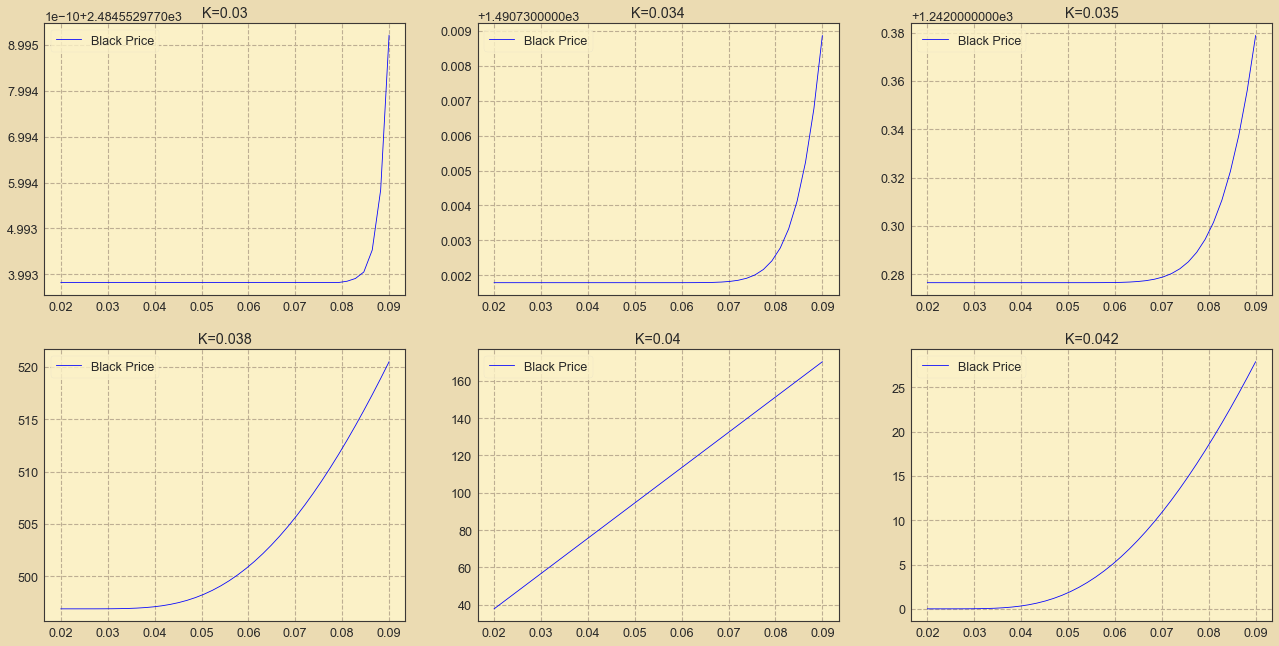

In [5]:
relat_black_sigma([0.030,0.034,0.035,0.038,0.04,0.042]) 

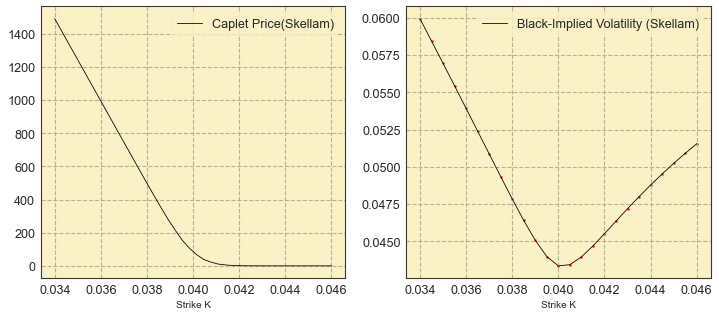

In [6]:
plt.figure(figsize=(12,5), facecolor='white')

''' Strike K '''

ax1 = plt.subplot(121)
x_1 = np.linspace(0.034,0.046,40)
y_1 = [call_Cpl(K=i, lambda_2=0.5, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021))*1000000 for i in x_1]
ax1.plot(x_1, y_1, lw=0.8, color='black')
ax1.set_xlabel(u'Strike K',fontsize=10)
# plt.yticks(list(np.arange()))
ax1.legend(['Caplet Price(Skellam)'],loc=0)
ax1.grid('True',ls='--')

''' Black-Implied Volatility '''

ax2 = plt.subplot(122)
x_2 = [0.034+0.0005*i for i in range(25)]
y_2 = [black_call_imp_vol_dichotomy(c=call_Cpl(K=i, lambda_2=0.5, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021)),
                                    K=i,
                                    start_date=ql.Date(1,1,2021),
                                    F_2_0=0.04,
                                    T_1=ql.Date(25,3,2021),
                                    T_2=ql.Date(25,6,2021)) for i in x_2]
ax2.plot(x_2, y_2, lw=0.8, color='black')
ax2.scatter(x_2, y_2, s=5, c='red')
ax2.set_xlabel(u'Strike K',fontsize=10)
ax2.legend(['Black-Implied Volatility (Skellam)'],loc='upper right')
ax2.grid('True',ls='--')

plt.show()

In [7]:
# MAIN FUNCTION 3

def bachelier_call_imp_vol_dichotomy(c, K, start_date, F_2_0, T_1, T_2, r=0.03, thresh=1e-16):
    '''
    c: the price of the ith caplet derived from SMM
    K: the strike of the 2nd caplet
    start_date: ql.Date object (the date of evaluation)
    F_2_0: the time-(start_date) simple forward rate for period [T_1,T_2]
    T_1: ql.Date object
    T_2: ql.Date object
    '''
    top = 3
    floor = 0.001
    sigma = (floor + top) / 2

    def f(sig):
        return 10000 * (c - bachelier_call_Cpl(K, start_date, F_2_0, T_1, T_2, sig, r=0.03))

    while abs(f(sigma)) > thresh:
        f_floor = f(floor)
        f_sig = f(sigma)
        if f_floor * f_sig < 0:
            floor = floor
            top = sigma
        else:
            floor = sigma
            top = top
        sigma = (floor + top) / 2
    return sigma

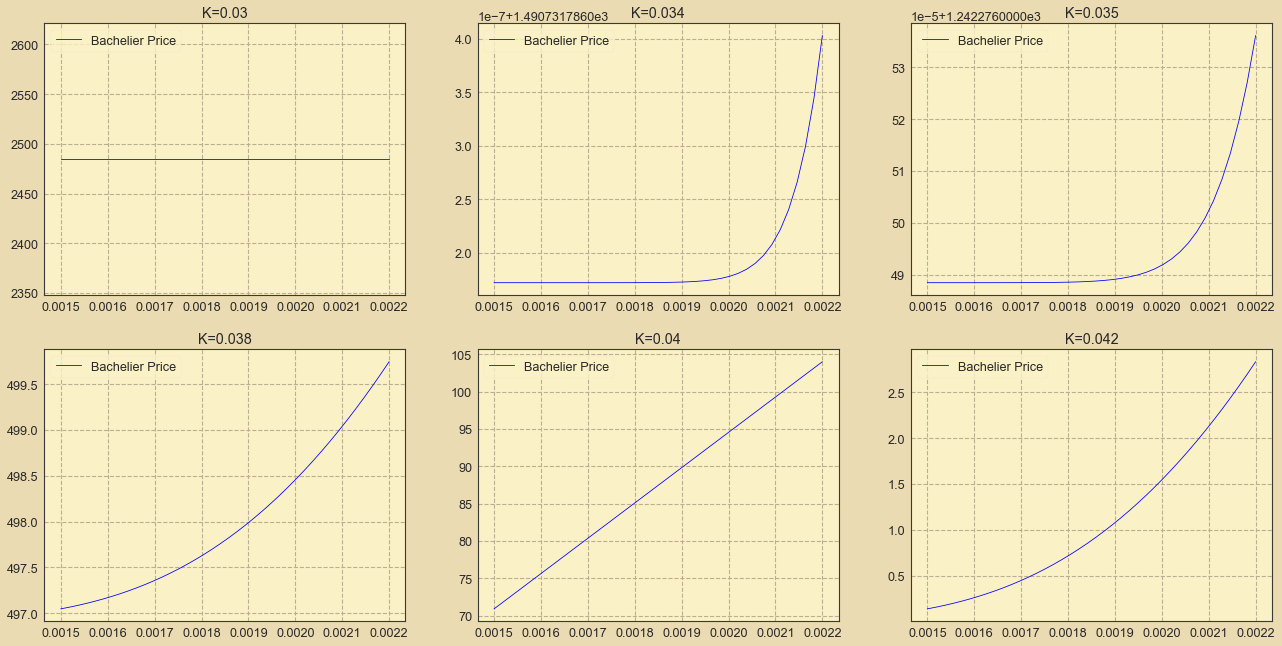

In [8]:
relat_bachelier_sigma([0.030,0.034,0.035,0.038,0.04,0.042])

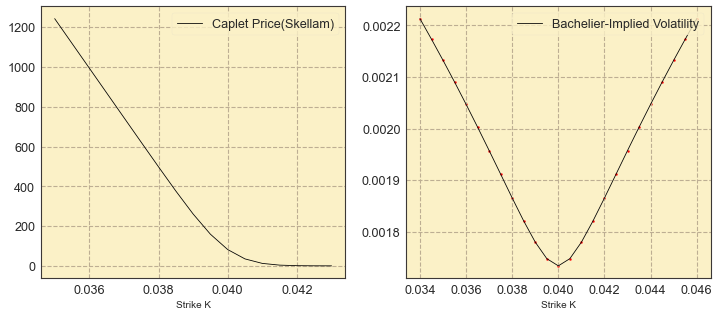

In [9]:
plt.figure(figsize=(12,5), facecolor='white')

''' Strike K '''
ax1 = plt.subplot(121)
x_1 = [0.035+0.0005*i for i in range(17)]
y_1 = [call_Cpl(K=i, lambda_2=0.5, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021))*1000000 for i in x_1]
ax1.plot(x_1, y_1, lw=0.8, color='black')
ax1.set_xlabel(u'Strike K',fontsize=10)
# plt.yticks(list(np.arange()))
ax1.legend(['Caplet Price(Skellam)'],loc=0)
ax1.grid('True',ls='--')

''' Bachelier-Implied Volatility '''
ax2 = plt.subplot(122)
# x_2 = [0.033+0.0002*i for i in range(60)]
x_2 = [0.034+0.0005*i for i in range(25)]
y_2 = [bachelier_call_imp_vol_dichotomy(c=call_Cpl(K=i, lambda_2=0.5, start_date=ql.Date(1,1,2021), F_2_0=0.04, T_1=ql.Date(25,3,2021), T_2=ql.Date(25,6,2021)),
                                    K=i,
                                    start_date=ql.Date(1,1,2021),
                                    F_2_0=0.04,
                                    T_1=ql.Date(25,3,2021),
                                    T_2=ql.Date(25,6,2021)) for i in x_2]
ax2.plot(x_2, y_2, lw=0.8, color='black')
ax2.scatter(x_2, y_2, s=5, c='red')
ax2.set_xlabel(u'Strike K',fontsize=10)
ax2.legend(['Bachelier-Implied Volatility'],loc='upper right')
ax2.grid('True',ls='--')

plt.show()